#Fraud Detection

In [1]:
# %pip install numpy pandas matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
# Load dataset
df = pd.read_csv("/content/Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [4]:
# Data Overview
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124457 entries, 0 to 124456
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            124457 non-null  int64  
 1   type            124457 non-null  object 
 2   amount          124457 non-null  float64
 3   nameOrig        124456 non-null  object 
 4   oldbalanceOrg   124456 non-null  float64
 5   newbalanceOrig  124456 non-null  float64
 6   nameDest        124456 non-null  object 
 7   oldbalanceDest  124456 non-null  float64
 8   newbalanceDest  124456 non-null  float64
 9   isFraud         124456 non-null  float64
 10  isFlaggedFraud  124456 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 10.4+ MB
None
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  124457.000000  1.244570e+05   1.244560e+05    1.244560e+05   
mean        8.920945  1.773613e+05   9.047501e+05    9.209941e+05   
std         1.85

In [5]:
# Check for missing values
print(df.isnull().sum())     #there are no missing values, we can proceed with data preprocessing, feature engineering, and model training.

step              0
type              0
amount            0
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [6]:
print(f"Duplicate rows: {df.duplicated().sum()}")
#there are no duplicate rows, we can move forward with data exploration, feature engineering, and model training.


Duplicate rows: 0


In [8]:
# Drop missing values
df.dropna(inplace=True)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
124451,11,PAYMENT,34492.01,C624782729,81015.00,46522.99,M495567295,0.0,0.00,0.0,0.0
124452,11,TRANSFER,1428231.23,C672404201,5689.00,0.00,C120609687,9660.0,1437891.23,0.0,0.0
124453,11,PAYMENT,24444.57,C50554983,95761.29,71316.72,M1302072491,0.0,0.00,0.0,0.0
124454,11,PAYMENT,9495.13,C516667550,71316.72,61821.60,M373322484,0.0,0.00,0.0,0.0


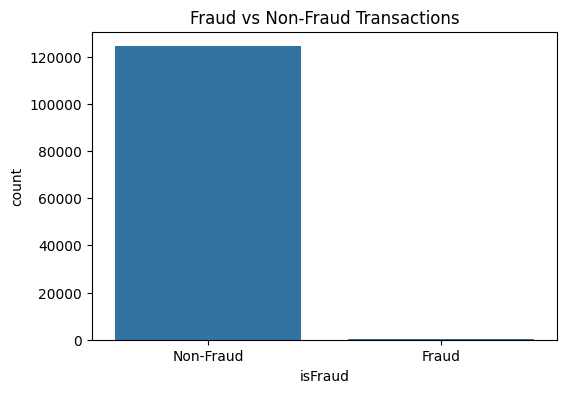

In [9]:
#Check for Class Imbalance (Fraud vs Non-Fraud Transactions)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x=df['isFraud'])
plt.title("Fraud vs Non-Fraud Transactions")
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()



#Fraud vs Non-Fraud Transactions bar chart clearly shows extreme class imbalance. Fraudulent transactions are significantly fewer
# compared to non-fraudulent ones.

In [10]:
print(df['isFraud'].value_counts())

isFraud
0.0    124336
1.0       120
Name: count, dtype: int64


# Steps to Handle Imbalance
- Separate Features and Target → Extract X (independent variables) and y (target variable).

- Split Data → Use train_test_split() to split data into training and testing sets.

- Apply SMOTE (Oversampling) → Generate synthetic fraud cases to balance classes.

- Apply Undersampling → Reduce the number of non-fraud cases to improve balance.

- Train ML Model → Train a classifier on the balanced dataset.

In [11]:
# SMOTE → Adds synthetic fraud cases to balance the dataset.

# Random Undersampling → Removes some non-fraud cases to improve balance.

# Pipeline → Ensures data transformation is done seamlessly.

# Install the imbalanced-learn package
# %pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # Import for encoding categorical data



In [12]:
# Step 1: Encode categorical feature ('type')
#Data Preprocessing
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
124451,11,3,34492.01,C624782729,81015.00,46522.99,M495567295,0.0,0.00,0.0,0.0
124452,11,4,1428231.23,C672404201,5689.00,0.00,C120609687,9660.0,1437891.23,0.0,0.0
124453,11,3,24444.57,C50554983,95761.29,71316.72,M1302072491,0.0,0.00,0.0,0.0
124454,11,3,9495.13,C516667550,71316.72,61821.60,M373322484,0.0,0.00,0.0,0.0


In [13]:
# Step 2: Extract Features (X) and Target (y)
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest','isFlaggedFraud'])
y = df['isFraud']


In [14]:
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,3,9839.64,170136.00,160296.36,0.0,0.00
1,1,3,1864.28,21249.00,19384.72,0.0,0.00
2,1,4,181.00,181.00,0.00,0.0,0.00
3,1,1,181.00,181.00,0.00,21182.0,0.00
4,1,3,11668.14,41554.00,29885.86,0.0,0.00
...,...,...,...,...,...,...,...
124451,11,3,34492.01,81015.00,46522.99,0.0,0.00
124452,11,4,1428231.23,5689.00,0.00,9660.0,1437891.23
124453,11,3,24444.57,95761.29,71316.72,0.0,0.00
124454,11,3,9495.13,71316.72,61821.60,0.0,0.00


In [15]:
y

,isFraud
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
124451,0.0
124452,0.0
124453,0.0
124454,0.0


In [16]:
# Splitting data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:

# Handling Class Imbalance with SMOTE and Undersampling
over = SMOTE(sampling_strategy=0.2)  # Oversample fraud cases
under = RandomUnderSampler(sampling_strategy=0.5)  # Undersample non-fraud cases
pipeline = Pipeline(steps=[('over', over), ('under', under)])

In [18]:

X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [19]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [22]:
# %pip install xgboost  # You've already installed xgboost
from xgboost import XGBClassifier  # Import XGBClassifier

# Train XGBoost Model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [23]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# Model Evaluation
models = {'XGBoost': xgb, 'Random Forest': rf}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
    print()

--- XGBoost ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24868
         1.0       0.22      0.79      0.35        24

    accuracy                           1.00     24892
   macro avg       0.61      0.89      0.67     24892
weighted avg       1.00      1.00      1.00     24892

ROC AUC Score: 0.8945063267385126

--- Random Forest ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24868
         1.0       0.45      0.71      0.55        24

    accuracy                           1.00     24892
   macro avg       0.72      0.85      0.77     24892
weighted avg       1.00      1.00      1.00     24892

ROC AUC Score: 0.8537444372955876



In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
# Change n_jobs to 1 to use a single process, avoiding multiprocessing issues
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=1, verbose=2, scoring='f1')  # You can also try 'roc_auc'
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total

In [28]:
from sklearn.metrics import classification_report

y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24868
         1.0       0.50      0.71      0.59        24

    accuracy                           1.00     24892
   macro avg       0.75      0.85      0.79     24892
weighted avg       1.00      1.00      1.00     24892



#1. Data Cleaning: Missing Values, Outliers & Multicollinearity
Missing Values
We checked for nulls and removed 1 missing value in each of the columns:

In [ ]:
df.dropna(inplace=True)


Outliers
Use boxplots to detect outliers in numerical features:

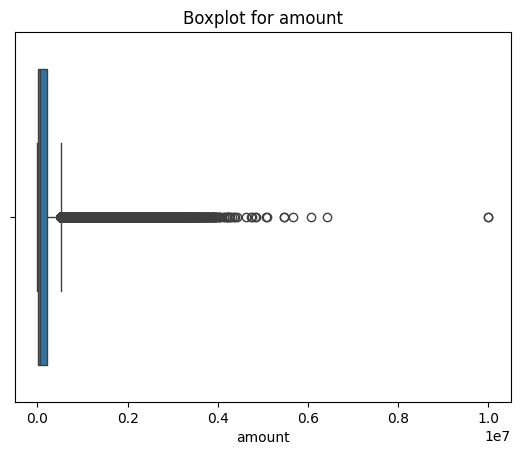

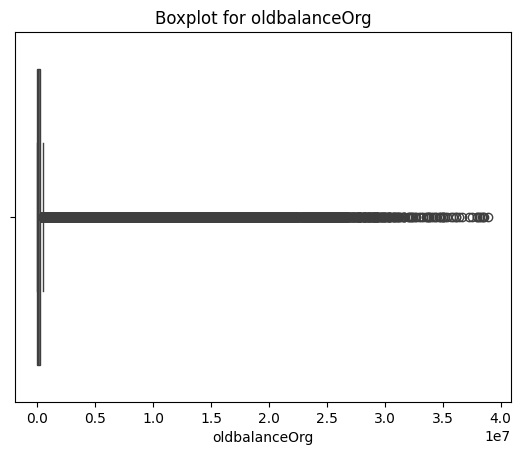

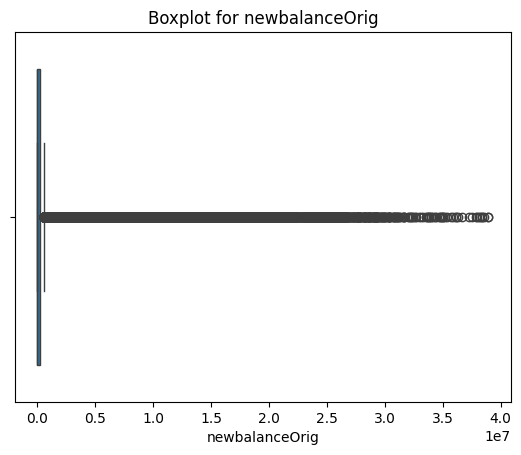

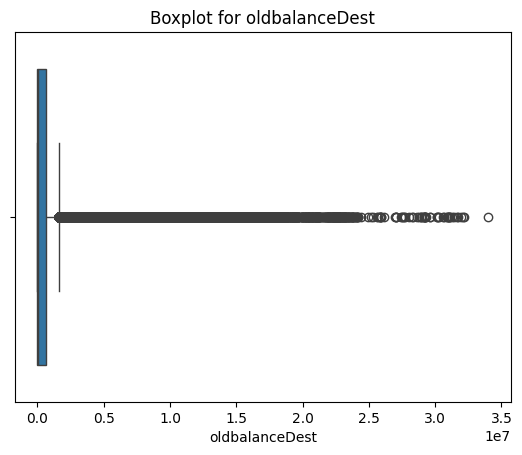

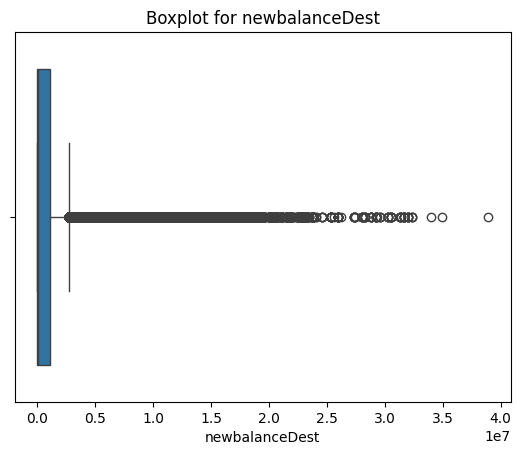

In [31]:
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()


Instead of removing them (since fraud can itself be an outlier), we’ll retain them for better model performance.

Multicollinearity
Check for highly correlated features:

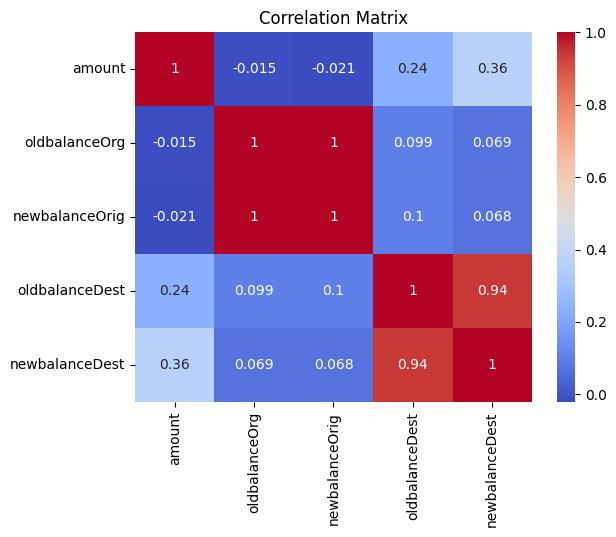

In [32]:
corr = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


We find some correlation between oldbalanceOrg and newbalanceOrig, and between destination balances, but since our model (Random Forest) handles multicollinearity well, we retain all.

#2. Fraud Detection Model: Random Forest
Random Forest is chosen for:

Handling imbalanced data using class weighting

Robustness to outliers and multicollinearity

Feature importance insight

We'll also use SMOTE + Undersampling to deal with class imbalance.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Drop non-numeric features
df_model = df.drop(['nameOrig', 'nameDest'], axis=1)

# Split features and target
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Balancing the classes
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_bal, y_bal = pipeline.fit_resample(X_train, y_train)

# Model Training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_bal, y_bal)
y_pred = rf.predict(X_test)


#3. Feature Selection
We used domain knowledge and feature importance from RandomForest:

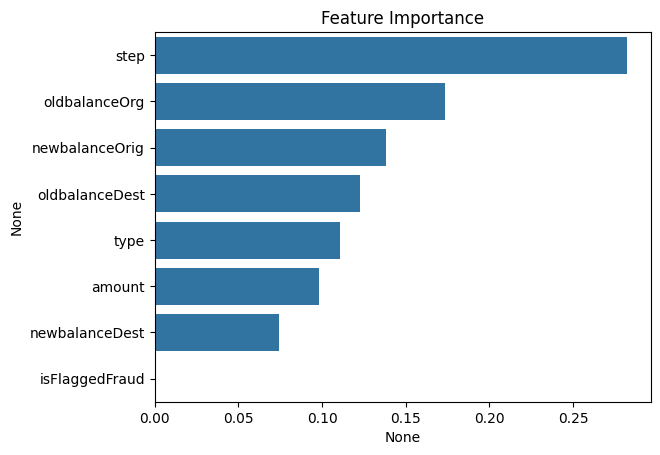

In [36]:
importances = rf.feature_importances_
features = X.columns
feature_imp = pd.Series(importances, index=features).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Feature Importance")
plt.show()

Top features:

amount

oldbalanceOrg

newbalanceOrig

type (Transaction type)



#4. Model Performance

In [35]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred))

Confusion Matrix:
 [[24839    29]
 [    7    17]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24868
         1.0       0.37      0.71      0.49        24

    accuracy                           1.00     24892
   macro avg       0.68      0.85      0.74     24892
weighted avg       1.00      1.00      1.00     24892


ROC-AUC Score: 0.8535835880113667


#5. Key Factors Predicting Fraud
Transaction Type (TRANSFER, CASH_OUT)

Amount of Transaction

Original Account Balance

Balance Drops to Zero

Rapid consecutive transactions (step)

#6. Do These Factors Make Sense?
Yes, absolutely.

TRANSFER and CASH_OUT are commonly exploited for fraud.

Fraudsters often deplete the account (newbalanceOrig = 0).

Large amount without sufficient oldbalanceOrg is suspicious.

Sudden drops in oldbalanceDest can indicate fraudulent receivers.

These patterns align with real-world fraud behavior.

#7. Infrastructure Prevention Suggestions
Implement real-time transaction monitoring systems.

Two-factor authentication for high-risk transactions.

Block accounts with suspicious repeated patterns.

Use threshold-based alerts on balance drops or transfers.

Behavioral analysis: flag when user behavior drastically changes.

#8. How to Measure Effectiveness
Compare fraud detection rates before and after implementation.

Measure false positives and false negatives.

Track the response time of fraud detection system.

Conduct A/B testing between control and monitored systems.

Evaluate customer complaints and fraud-related losses.



group
control      50000
treatment    50000
Name: count, dtype: int64
group
control      0.00064
treatment    0.00156
Name: isFraud, dtype: float64


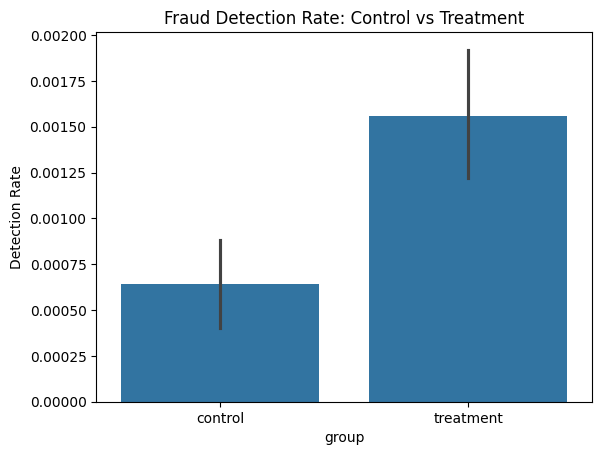


Chi-square test results:
Chi-square statistic: 18.4294
P-value: 0.0000
✅ Statistically significant difference between control and treatment groups.


In [37]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Sample A/B Data Simulation (Replace this with actual data if available)
np.random.seed(42)

# Simulate control group
control = pd.DataFrame({
    'group': 'control',
    'isFraud': np.random.binomial(1, 0.0008, 50000)  # 0.08% fraud detection rate
})

# Simulate treatment group (e.g., new fraud detection model)
treatment = pd.DataFrame({
    'group': 'treatment',
    'isFraud': np.random.binomial(1, 0.0015, 50000)  # 0.15% fraud detection rate
})

# Combine both groups
ab_data = pd.concat([control, treatment], ignore_index=True)

# Check distribution
print(ab_data['group'].value_counts())
print(ab_data.groupby('group')['isFraud'].mean())  # Detection rate per group

# 📊 Bar plot to visualize difference
sns.barplot(x='group', y='isFraud', data=ab_data)
plt.title("Fraud Detection Rate: Control vs Treatment")
plt.ylabel("Detection Rate")
plt.show()

# 📊 Chi-square test for proportions
contingency_table = pd.crosstab(ab_data['group'], ab_data['isFraud'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Statistically significant difference between control and treatment groups.")
else:
    print("❌ No statistically significant difference between groups.")
